# Set up

In [2]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [6]:
filepath_data = "C:\\Users\\15126\\Desktop\\Chicago\\Autumn\\Portfolio Management\\finm36700\\multi_asset_etf_data.xlsx"
info = pd.read_excel(filepath_data,sheet_name='descriptions') # information of asset classes indexed by ticker
info.set_index('ticker',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns') # total returns of asset classes indexed by date
rets.set_index('Date',inplace=True)

In [7]:
symbol_list = info.index
rets = rets[symbol_list]

## Data

In [8]:
rets.drop(columns=['QAI'],inplace=True) # drop QAI due to complications related to optimal holding being a short position
# Setting risk-free rate as money market fund
TICK_RF = 'SHV'
rf = rets[TICK_RF]
retsx = rets.sub(rf,axis=0)
retsx.drop(columns=['SHV'],inplace=True)

# 1. Summary Statistics

### Calculate and display the mean and volatility of each asset’s excess return. (Recall we use volatility to refer to standard deviation.)

In [9]:
# Summary Statistics - Annualize monthly returns, volatility, and Sharpe ratio
annual_mean = retsx.mean()*12
annual_vol = retsx.std()*np.sqrt(12)
annual_sharpe = annual_mean/annual_vol

In [10]:
# Plot Summary Statistics in Table
summary_stats = pd.DataFrame({'Annualized Mean':annual_mean,
                              'Annualized Volatility':annual_vol,
                              'Annualized Sharpe Ratio':annual_sharpe})
display(summary_stats) # Display summary statistics

,Annualized Mean,Annualized Volatility,Annualized Sharpe Ratio
SPY,0.1281,0.1428,0.8971
EFA,0.0618,0.1509,0.4094
EEM,0.0293,0.1762,0.1665
PSP,0.0926,0.2134,0.4338
HYG,0.0414,0.0759,0.5449
DBC,-0.0053,0.1666,-0.0318
IYR,0.0749,0.1687,0.4441
IEF,0.0164,0.0634,0.2586
BWX,-0.0077,0.0828,-0.0932
TIP,0.0205,0.0511,0.4011


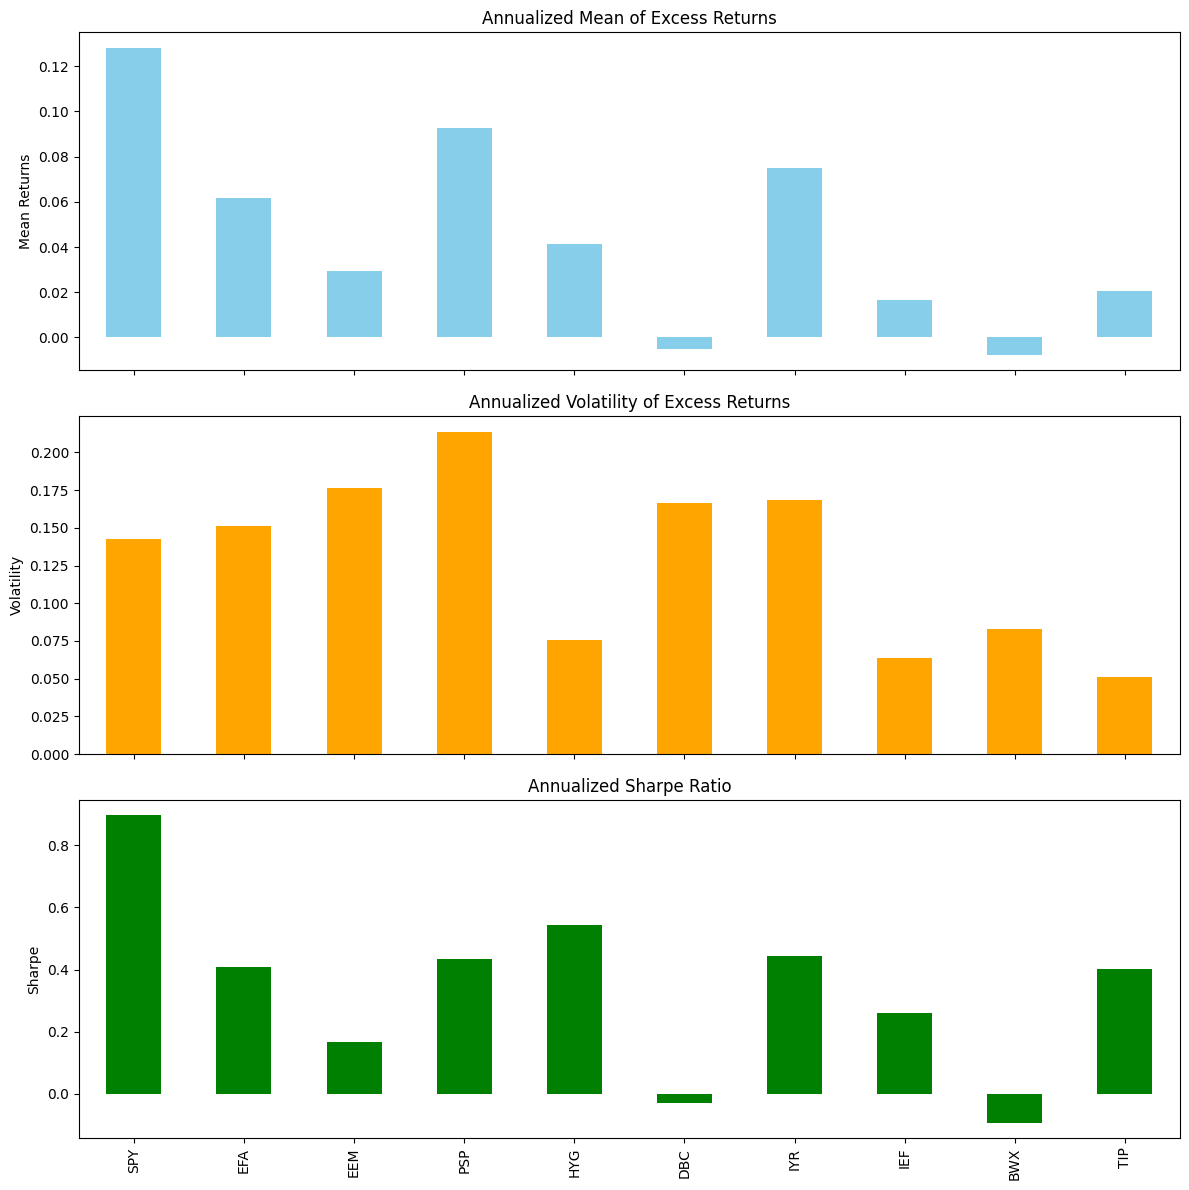

In [11]:
# Plot Summary Statistics in Three Bar Charts
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

summary_stats["Annualized Mean"].plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Annualized Mean of Excess Returns")
axes[0].set_ylabel("Mean Returns")

summary_stats["Annualized Volatility"].plot(kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Annualized Volatility of Excess Returns")
axes[1].set_ylabel("Volatility")

summary_stats["Annualized Sharpe Ratio"].plot(kind="bar", ax=axes[2], color="green")
axes[2].set_title("Annualized Sharpe Ratio")
axes[2].set_ylabel("Sharpe")

plt.tight_layout()
plt.show()

### Which assets have the best and worst Sharpe ratios?

In [12]:
min_sharpe_asset = summary_stats['Annualized Sharpe Ratio'].idxmin() # Worst Sharpe ratio asset
max_sharpe_asset = summary_stats['Annualized Sharpe Ratio'].idxmax() # Best Sharpe ratio asset
print(min_sharpe_asset)
print(max_sharpe_asset)

BWX
SPY


Typically, an asset with a Sharpe ratio above 1 is considered strong, as it indicates that returns are high relative to risk. Conversely, a low or negative Sharpe ratio suggests that the asset is delivering little to no compensation for the risk taken—in fact, negative values imply that the investor would have been better off holding a risk-free asset.

In this analysis, the asset with the lowest Sharpe ratio is BWX, with a value of –0.0932, meaning its returns did not justify its risk. By contrast, the asset with the highest Sharpe ratio is SPY, at 0.8971, which is below the threshold of 1 but still indicates comparatively better risk-adjusted performance than the other assets.

# 2. Descriptive Analysis

## Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?

In [13]:
def plot_corr_matrix(
    df: pd.DataFrame,
    method: str = 'pearson',
    triangle: str = 'full',          # 'full' | 'upper' | 'lower'
    figsize: tuple = (10, 10),
    cmap: str = 'coolwarm',
    annot: bool = True,
    fmt: str = '.2f',
):
    """
    Plot a correlation-matrix heatmap with optional triangle masking,
    highlighting the global max (red) and min (blue) within the visible area.
    """
    # 1) compute corr and blank out the diagonal
    corr = df.corr(method=method).astype(float)
    np.fill_diagonal(corr.values, np.nan)

    # 2) build mask for upper/lower if requested
    if triangle == 'upper':
        mask = np.tril(np.ones_like(corr.values, dtype=bool), k=0)  # hide lower + diagonal
    elif triangle == 'lower':
        mask = np.triu(np.ones_like(corr.values, dtype=bool), k=0)  # hide upper + diagonal
    else:  # 'full'
        mask = None

    # 3) draw the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        corr,
        mask=mask,
        annot=annot,
        fmt=fmt,
        cmap=cmap,
        ax=ax,
        square=True,
        cbar_kws={'shrink': 0.8}
    )

    # 4) find & highlight global max/min **within the visible region only**
    arr = corr.values.copy()
    if mask is not None:
        arr[mask] = np.nan  # ignore the hidden half when finding extrema

    # skip if everything is NaN (tiny frames)
    if np.isfinite(arr).any():
    # strongest correlation (max |corr|)
        mag = np.abs(arr)
        max_mag = np.nanmax(mag)
        max_positions = np.argwhere(mag == max_mag)
    # least correlated (closest to 0)
        min_mag = np.nanmin(mag)
        min_positions = np.argwhere(mag == min_mag)

    # Draw red box for strongest correlation
    for r, c in max_positions:
        ax.add_patch(plt.Rectangle((c, r), 1, 1,
                                   facecolor='red', alpha=0.25, zorder=4))
        ax.add_patch(plt.Rectangle((c, r), 1, 1,
                                   fill=False, edgecolor='red',
                                   linewidth=2, zorder=5))

    # Draw blue box for least correlation
    for r, c in min_positions:
        ax.add_patch(plt.Rectangle((c, r), 1, 1,
                                   facecolor='blue', alpha=0.25, zorder=4))
        ax.add_patch(plt.Rectangle((c, r), 1, 1,
                                   fill=False, edgecolor='blue',
                                   linewidth=2, zorder=5))


    ax.set_title(f"Correlation matrix ({triangle} triangle, method={method})")
    plt.tight_layout()
    return fig, ax

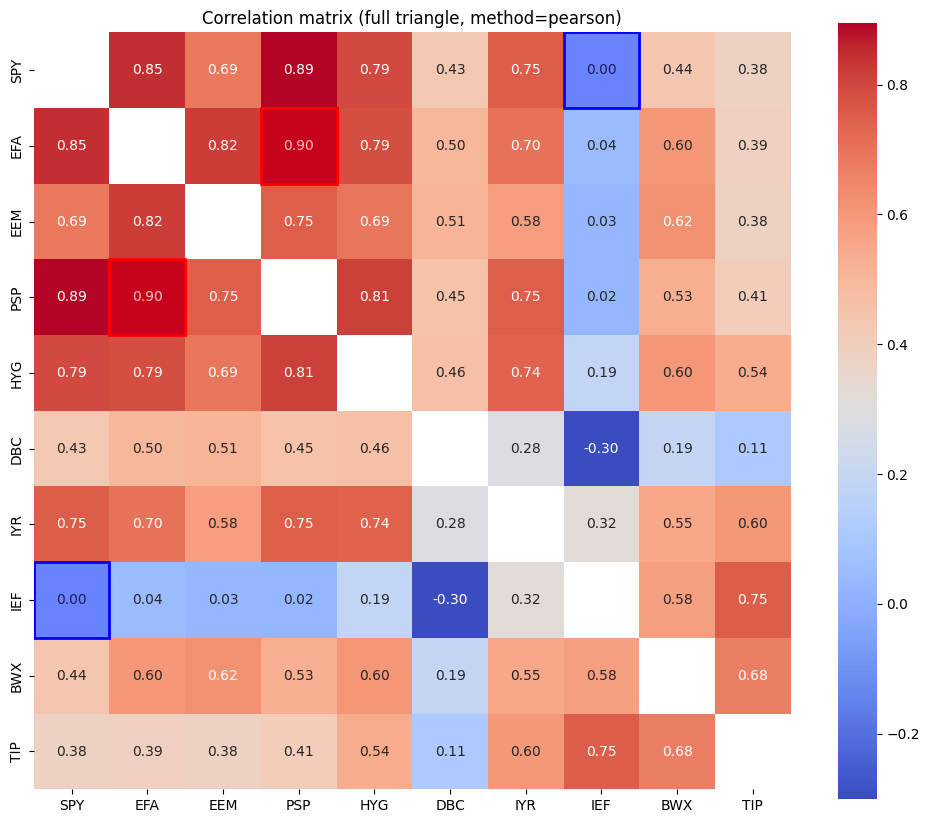

In [14]:
fig, ax = plot_corr_matrix(
    retsx,
    triangle='full',    # shows both upper & lower
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    figsize=(10, 10)
)


From the correlation map, we observe a range of relationships. The strongest correlation is between PSP and EFA (0.90), while the weakest correlation, closest to zero, is between IEF and SPY.

## How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

In [15]:
# Function to calculate performance metrics
def performanceMetrics(returns,annualization=1):
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics

In [16]:
mets = performanceMetrics(retsx,annualization=12)
mets.sort_values('Sharpe',ascending=False).style.format('{:.1%}')

,Mean,Vol,Sharpe,Min,Max
SPY,12.8%,14.3%,89.7%,-12.9%,12.7%
HYG,4.1%,7.6%,54.5%,-10.4%,8.6%
IYR,7.5%,16.9%,44.4%,-20.0%,13.3%
PSP,9.3%,21.3%,43.4%,-27.8%,17.9%
EFA,6.2%,15.1%,40.9%,-14.5%,14.3%
TIP,2.1%,5.1%,40.1%,-6.7%,4.3%
IEF,1.6%,6.3%,25.9%,-4.7%,4.7%
EEM,2.9%,17.6%,16.7%,-17.9%,16.3%
DBC,-0.5%,16.7%,-3.2%,-17.7%,10.3%
BWX,-0.8%,8.3%,-9.3%,-6.9%,7.8%


From the table above, we can compare the mean returns of Treasury Inflation-Protected Securities (TIP) to domestic bonds (IEF): 2.1% vs. 1.6%. This suggests that TIP outperformed IEF while also exhibiting lower volatility and a higher Sharpe ratio. When compared to foreign bonds, which posted a –0.8% return, TIP performed significantly better.

# 3. The MV frontier

## Compute and display the weights of the tangency portfolio: $w^{(\text{tan})}$


In [17]:
## Important functions needed to calculate tangency portfolio weights and perform sanity check
def sanity_check_tangency_from_returns(returns_df, extreme_factor: float = 3.0):
    """
    Compute on a returns DataFrame directly (e.g. excess returns).
    """
    cov     = returns_df.cov()
    mu      = returns_df.mean()

    invS    = np.linalg.inv(cov.values)
    one     = np.ones(mu.shape[0])

    A       = one @ invS @ one
    B       = one @ invS @ mu.values
    C       = mu.values @ invS @ mu.values

    mu_gmv  = B / A
    mu_tan  = C / B

    max_asset = np.max(np.abs(mu.values))
    threshold = extreme_factor * max_asset

    branch = 'upper (efficient)' if mu_gmv > 0 else 'lower'
    print(f"GMV mean (unscaled) : {mu_gmv:.6f} → tangency on the {branch} branch")
    print(f"Tangency mean       : {mu_tan:.6f}")
    print(f"Max |asset mean|    : {max_asset:.6f}")
    print(f"Threshold ({extreme_factor}×): {threshold:.6f}")

    if abs(mu_tan) >= threshold:
        print("🚩 EXTREME scaling: |μ_tan| exceeds threshold")
    else:
        print("✓ Scaling looks reasonable")


def tangency_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    return pd.DataFrame(weights, index=returns.columns)

In [18]:
## Perform sanity check on tangency portfolio calculated from returns
sanity_check_tangency_from_returns(retsx)

GMV mean (unscaled) : 0.002250 → tangency on the upper (efficient) branch
Tangency mean       : 0.010710
Max |asset mean|    : 0.010678
Threshold (3.0×): 0.032035
✓ Scaling looks reasonable


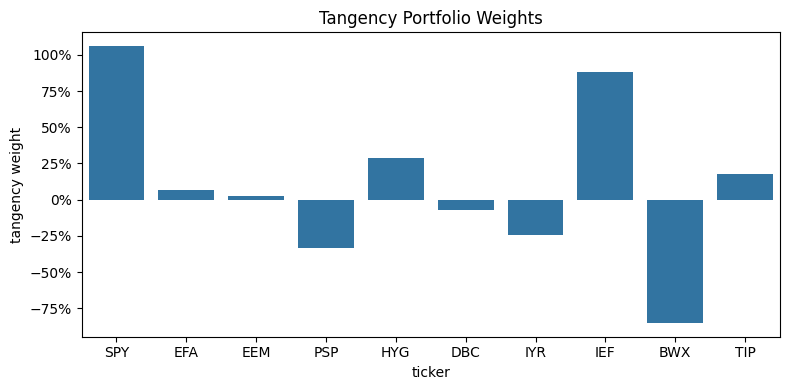

In [19]:
## Compute and display the weights of the tangency portfolio: 

import matplotlib.ticker as mtick

wts = pd.DataFrame(index=retsx.columns)
wts['tangency'] = tangency_weights(retsx)

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x=wts.index, y='tangency', data=wts, ax=ax)

# same formatter
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.set_title('Tangency Portfolio Weights')
ax.set_ylabel('tangency weight')
ax.set_xlabel('ticker')
plt.tight_layout()
plt.show()

## Does the ranking of weights align with the ranking of Sharpe ratios?

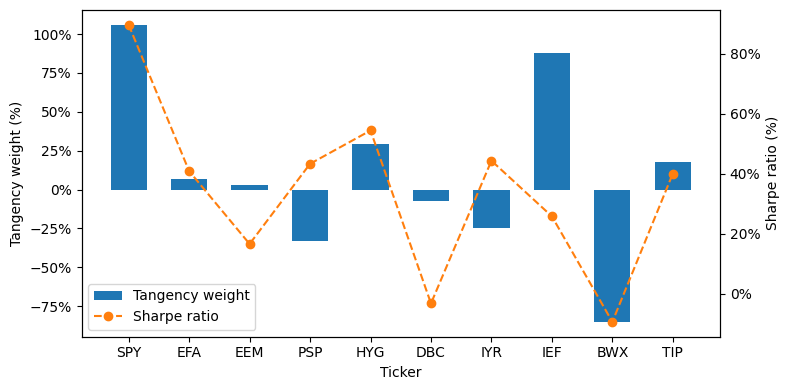

In [20]:
import matplotlib.ticker as mtick

labels = wts.index.tolist()        
x      = np.arange(len(labels))    
width  = 0.6                       

fig, ax1 = plt.subplots(figsize=(8,4))
ax2      = ax1.twinx()

bars1 = ax1.bar(
    x,
    wts['tangency'],
    width,
    label='Tangency weight',
    color='C0'
)

line2, = ax2.plot(
    x,
    mets.loc[labels, 'Sharpe'],
    marker='o',
    linestyle='--',
    label='Sharpe ratio',
    color='C1'
)

ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Ticker')

ax1.set_ylabel('Tangency weight (%)')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

ax2.set_ylabel('Sharpe ratio (%)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='lower left')

plt.tight_layout()
plt.show()

The rankings do not perfectly align. 

SPY: Highest Sharpe ratio → Highest positive weight (aligned).

BWX: Lowest Sharpe ratio → Large negative weight (aligned).

But there are exceptions — for example:

HYG has a middling Sharpe ratio but gets a large positive weight.

IEF also has a moderate Sharpe ratio but a very high positive weight.

## Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to $w^{(\text{tan})}$

In [21]:
retsx_tan = pd.DataFrame(retsx @ wts['tangency'], columns=['tangency'])
mets_tan = performanceMetrics(pd.concat([retsx, retsx_tan], axis=1), annualization=12)
sorted_df = mets_tan.sort_values('Sharpe', ascending=False)
to_highlight = ['tangency']

# Simply display the sorted table
sorted_df


,Mean,Vol,Sharpe,Min,Max
tangency,0.1285,0.0875,1.4692,-0.0508,0.0823
SPY,0.1281,0.1428,0.8971,-0.1285,0.1273
HYG,0.0414,0.0759,0.5449,-0.1039,0.0855
IYR,0.0749,0.1687,0.4441,-0.2000,0.1325
PSP,0.0926,0.2134,0.4338,-0.2784,0.1789
EFA,0.0618,0.1509,0.4094,-0.1447,0.1434
TIP,0.0205,0.0511,0.4011,-0.0671,0.0427
IEF,0.0164,0.0634,0.2586,-0.0471,0.0466
EEM,0.0293,0.1762,0.1665,-0.1786,0.1633
DBC,-0.0053,0.1666,-0.0318,-0.1771,0.1027


# 4. TIPS

Assess how much the tangency portfolio (and performance) change if…

 - TIPS are dropped completely from the investment set.

 - The expected excess return to TIPS is adjusted to be 0.0012 higher than what the historic sample shows.

Based on the analysis, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

,Mean,Vol,Sharpe,Min,Max
tangency,0.1285,0.0875,1.4692,-0.0508,0.0823
tangency adj,0.1204,0.0746,1.6124,-0.0490,0.0847


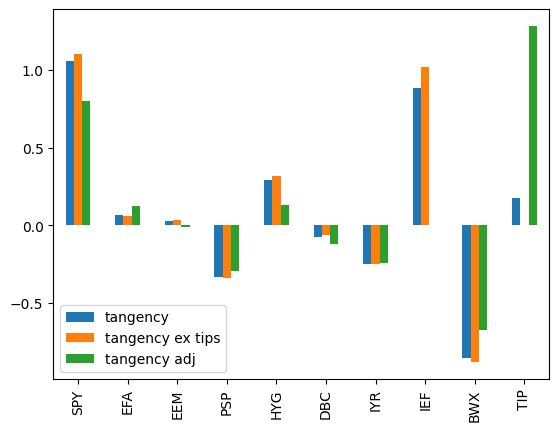

In [22]:
# --- Start from your existing objects: retsx (asset return matrix), wts (weights), mets_tan (baseline metrics)

# 1) baseline weights column already present
wts_adj = wts[['tangency']].copy()

# 2) No-TIPS tangency weights
#    Drop TIP from returns universe, compute weights, then add TIP back as 0 so columns/plots align
w_no_tips = tangency_weights(retsx.drop(columns=['TIP']))
wts_adj['tangency ex tips'] = w_no_tips.reindex(retsx.columns).fillna(0.0)

# 3) Bump TIPS expected return by +0.0012 (per period)
TIPS_ADJ = 0.0012  # if your returns are monthly, this is +0.12% per month

retsx_adj = retsx.copy()
retsx_adj['TIP'] = retsx_adj['TIP'] + TIPS_ADJ

# Recompute tangency with the adjusted TIPS mean
wts_adj['tangency adj'] = tangency_weights(retsx_adj)

# --- Quick bar plot of weights across scenarios (optional)
wts_adj.plot.bar()

# --- Compute portfolio returns & metrics for the adjusted scenario
retsx_tan_adj = pd.DataFrame(retsx_adj @ wts_adj['tangency adj'], columns=['tangency adj'])

# If performanceMetrics expects a DataFrame, pass a DataFrame (not a Series)
mets_adj = performanceMetrics(retsx_adj @ wts_adj[['tangency adj']], annualization=12)

# --- Compare baseline tangency vs adjusted tangency
pd.concat([mets_tan.loc[['tangency']], mets_adj])


Dropping TIPS barely changes the portfolio—the chart shows nearly identical blue (baseline) and orange (no TIPS) bars, confirming little impact on weights or performance.

When TIPS’ expected return rises slightly, the green bars show a large jump in the TIP allocation and a moderate boost in performance.

So, TIPS modestly expand diversification—mainly versus bonds—but their overall impact is limited. One could reasonably treat them as either a separate asset or part of the bond allocation.

# Allocations

### Equally-weighted (EW)

Rescale the entire weighting vector to have a target mean excess return of 
$\tilde{\mu}^{\text{port}}$. 

Thus, the *i*-th element of the weight vector is:

$$
w_i^{\text{EW}} = \frac{1}{n}
$$



In [29]:
# Compute expected excess returns (mean per asset)
mu = retsx.mean()
n = len(mu) # Number of Assets in Portfolio
w_EW = np.ones(n) / n # Equal wiehgting
mu_EW = float(w_EW @ mu) # Current mean excess return 

# Scale to target monthly mean excess return of 0.01
target = 0.01
b = target / mu_EW
w_EW_target = b * w_EW

print("Scaling factor:", b)
print("Sum of weights:", w_EW_target.sum())
print("Targeted equally-weighted weights:\n", pd.Series(w_EW_target, index=mu.index))


Scaling factor: 2.654862788623331
Sum of weights: 2.6548627886233316
Targeted equally-weighted weights:
 SPY   0.2655
EFA   0.2655
EEM   0.2655
PSP   0.2655
HYG   0.2655
DBC   0.2655
IYR   0.2655
IEF   0.2655
BWX   0.2655
TIP   0.2655
dtype: float64


### “Risk-parity” (RP)

Risk-parity is a term used in a variety of ways, but here we set the weight of the portfolio 
to be proportional to the inverse of its full-sample variance estimate.  
Thus, the *i*-th element of the weight vector is:

$$
w_i^{\text{RP}} = \frac{1}{\sigma_i^2}
$$


In [30]:
sigma = retsx.std()
w_RP = 1 / (sigma ** 2) # Compute inverse-variance weights (1 / sigma^2)

# Normalize so the weights sum to 1
w_RP = w_RP / w_RP.sum()

mu = retsx.mean() # Compute portfolio mean excess return
mu_RP = float(w_RP @ mu)

# Scale to target monthly mean of 0.01
target = 0.01
b = target / mu_RP
w_RP_target = b * w_RP

print("Scaling factor:", b)
print("Sum of weights:", w_RP_target.sum())
print("Risk-Parity Targeted Weights:\n", w_RP_target)


Scaling factor: 4.330847429685506
Sum of weights: 4.330847429685507
Risk-Parity Targeted Weights:
 SPY   0.1816
EFA   0.1627
EEM   0.1194
PSP   0.0814
HYG   0.6427
DBC   0.1336
IYR   0.1302
IEF   0.9206
BWX   0.5406
TIP   1.4181
dtype: float64


### Regularized (REG)

Much like the Mean-Variance portfolio, set the weights proportional to  
$w^{\text{REG}} \sim \hat{\Sigma}^{-1} \tilde{\mu}$,  
but this time, use a *regularized covariance matrix*:

$$
\hat{\Sigma} = \frac{\Sigma + \Sigma_D}{2}
$$

where $\Sigma_D$ denotes a *diagonal* matrix of the security variances, with zeros in the off-diagonals.

Thus, $\hat{\Sigma}$ is obtained from the usual covariance matrix $\Sigma$,  
but by shrinking all the covariances to half their estimated values.


In [31]:
mu = retsx.mean()
Sigma = retsx.cov()
Sigma_D = np.diag(np.diag(Sigma))
Sigma_hat = 0.5 * (Sigma + Sigma_D)

# Compute unnormalized mean-variance weights
w_REG_unnorm = np.linalg.inv(Sigma_hat) @ mu
# Normalize
w_REG = w_REG_unnorm / w_REG_unnorm.sum()
# Compute portfolio mean excess return
mu_REG = float(w_REG @ mu)
# Scale to target monthly excess return of 0.01
target = 0.01
b = target / mu_REG
w_REG_target = b * w_REG

print("Scaling factor (b):", b)
print("Sum of weights:", w_REG_target.sum())
print("Regularized (REG) Targeted Weights:\n", pd.Series(w_REG_target, index=mu.index))


Scaling factor (b): 1.1096003518627566
Sum of weights: 1.1096003518627564
Regularized (REG) Targeted Weights:
 SPY    0.5952
EFA    0.0694
EEM   -0.0780
PSP    0.0245
HYG    0.3774
DBC   -0.1315
IYR    0.0379
IEF    0.3938
BWX   -0.6210
TIP    0.4418
dtype: float64


In [34]:
TARG_MEAN = 0.01
mu = retsx.mean()

wts = pd.DataFrame(index=retsx.columns)

# Base portfolios
wts['equal weights'] = 1 / len(retsx.columns)
wts['risk parity']   = 1 / retsx.var()
wts['regularized']   = tangency_weights(retsx, scale_cov=.5)
wts['tangency']      = tangency_weights(retsx)

# Rescale each column to hit target mean of 0.01
wts *= TARG_MEAN / (mu @ wts)

# Compute portfolio returns and performance
retsP = retsx @ wts
summary = pd.DataFrame({
    'mean': retsP.mean(),
    'vol':  retsP.std(ddof=1),
    'Sharpe': retsP.mean() / retsP.std(ddof=1)
})

summary



,mean,vol,Sharpe
equal weights,0.0100,0.0777,0.1287
risk parity,0.0100,0.0762,0.1313
regularized,0.0100,0.0305,0.3278
tangency,0.0100,0.0236,0.4241


All portfolios achieve the same mean (0.01), so differences reflect risk efficiency:

- Equal weights and risk parity are simple but inefficient.

- Regularization greatly improves performance by stabilizing covariance estimates.

- Tangency achieves the highest Sharpe ratio, representing the theoretical optimal trade-off between risk and return.

Overall, Tangency is the most efficient portfolio, but regularization offers a strong, more stable alternative.